In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import os
from scipy import stats

from ANEMO import read_edf

In [2]:
%matplotlib inline
fig_width = 15

from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

exp = []
for x in range(len(liste)) :
    if liste[x][0]=='enregistrement' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN']:#,'YK']:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [4]:
timeStr = {}
timeStr['AM'] = '2017-10-23_100057'
timeStr['BMC'] = '2017-09-26_095637'
timeStr['CS'] = '2017-10-03_134421'
timeStr['DC']= '2017-09-27_161040'
timeStr['FM'] = '2017-10-03_143803'
timeStr['IP'] = '2017-09-28_115250'
timeStr['LB'] = '2017-09-20_151043'
timeStr['OP'] = '2017-10-26_121823'
timeStr['RS'] = '2017-11-08_094717'
timeStr['SR'] = '2017-11-16_153313'
timeStr['TN'] = '2017-11-08_150410'
#timeStr['YK'] = '2017-11-17_172706'

In [5]:
gradient_deg_NAN = []
TargOn = []

for x in range(len(exp)) :
    gradient_deg_NAN.append([])
    TargOn.append([])
        
    N_blocks = exp[x]['N_blocks']
    N_trials = exp[x]['N_trials']
    sujet = exp[x]['observer'] # sujet

    resultats = os.path.join('data', 'enregistrement_' + sujet + '_' + timeStr[sujet] + '.asc')
    data = read_edf(resultats, 'TRIALID')
    
    for block in range(N_blocks) :
        gradient_deg_NAN[x].append([])
        TargOn[x].append([])
        
        for trial in range(N_trials) :
            trial_data = trial + N_trials*block
            
            data_x = data[trial_data]['x']
            trackertime = data[trial_data]['trackertime']
            TargetOn = data[trial_data]['events']['msg'][15][0]
            saccades = data[trial_data]['events']['Esac']
            t_0 = data[trial_data]['trackertime'][0]

            gradient_x = np.gradient(data_x) # gradient en px/ms
            gradient_deg = gradient_x * 1/exp[x]['px_per_deg'] * 1000 # gradient en deg/sec

            #-------------------------------------------------
            TargOn[x][block].append(TargetOn-t_0)
            #StimOn[x][block][trial] = StimulusOn-t_0
            
            #-------------------------------------------------
            # SUPPRESSION DES SACCADES
            #-------------------------------------------------
            gradient_deg_NAN[x][block].append(gradient_deg)
            for s in range(len(saccades)) :
                if saccades[s][1]-t_0+15 <= (len(trackertime)) :
                    for x_data in np.arange((saccades[s][0]-t_0-5), (saccades[s][1]-t_0+15)) :
                        gradient_deg_NAN[x][block][trial][x_data] = np.nan
                else :
                    for x_data in np.arange((saccades[s][0]-t_0-5), (len(trackertime))) :
                        gradient_deg_NAN[x][block][trial][x_data] = np.nan


# P_reel

In [6]:
def Trace_Moyenne_P_reel(delta, color, title, mean=False, pas_tps=10, ax=None, stop=710) :
    va_r, va_l = {}, {}
    
    PROBA = np.arange(0,1,delta)
    for p_r in PROBA :
        va_r[p_r], va_l[p_r] = [], []
        
    if mean is not True :
        pas_tps = 1
        
    for x in range(len(exp)) :

        N_blocks = exp[x]['N_blocks']
        N_trials = exp[x]['N_trials']
        p = exp[x]['p']
        
        for block in range(N_blocks) :
            for trial in range(N_trials) :                
                TargetOn = TargOn[x][block][trial]
                bino=p[trial, block, 0]
                p_reel = p[trial, block, 1]

                for p_r in PROBA :
                    if p_reel >= p_r and p_reel < (p_r + delta) :
                        if bino == 0 : # droite c'est 1 gauche c'est 0
                            va_l[p_r].append(gradient_deg_NAN[x][block][trial][TargetOn-300:TargetOn+700])
                        elif bino == 1 :
                            va_r[p_r].append(gradient_deg_NAN[x][block][trial][TargetOn-300:TargetOn+700])


    if ax is None :
        fig_width = 20
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, 1*fig_width/(1.6180*1)))
    ax.plot(np.zeros(stop), c='k', alpha=0.6)            
    x=0                      
    for p_r in PROBA :
        mean_va_r, mean_va_l = [], []
        std_va_r, std_va_l = [], []
        
        for tps in range(stop) :
            liste_r = []
            for a in range(len(va_r[p_r])) :
                liste_r.append(va_r[p_r][a][tps])
            mean_va_r.append(np.nanmean(liste_r))
            std_va_r.append(np.nanstd(liste_r))

            liste_l = []
            for b in range(len(va_l[p_r])) :
                liste_l.append(va_l[p_r][b][tps])
            mean_va_l.append(np.nanmean(liste_l))
            std_va_l.append(np.nanstd(liste_l))

            
        if mean is True :
            pipou = 0
            mean_m_r, mean_m_l = [], []
            std_m_r, std_m_l = [], []
            for pipou in np.arange(0,len(mean_va_l),pas_tps) :
                mean_m_r.append(np.nanmean(mean_va_r[pipou:pipou+pas_tps]))
                mean_m_l.append(np.nanmean(mean_va_l[pipou:pipou+pas_tps]))
                std_m_r.append(np.nanmean(std_va_r[pipou:pipou+pas_tps]))
                std_m_l.append(np.nanmean(std_va_l[pipou:pipou+pas_tps]))

        else :
            mean_m_r, mean_m_l = mean_va_r, mean_va_l
            std_m_r, std_m_l = std_va_r, std_va_l
            
        mean_r = np.asarray(mean_m_r)
        mean_l = np.asarray(mean_m_l)
        std_r = np.asarray(std_m_r)
        std_l = np.asarray(std_m_l)
        
        ax.plot(mean_r, c=color[x], lw=3, alpha=1, label=' p = %.1f - %.1f'%(p_r, p_r+delta))
        #ax.plot(mean_l, c=color[x], lw=2.5, alpha=1)
        ax.fill_between(range(int(stop/pas_tps)), mean_r+std_r, mean_r-std_r, facecolor=color[x], alpha=0.05)
        #ax.fill_between(range(int(stop/pas_tps)), mean_l+std_l, mean_l-std_l, facecolor=color[x], alpha=0.05)
        
        x=x+1 

    ax.axvspan(0, int(300/pas_tps), color='r', alpha=0.2)
    ax.axvspan(int(300/pas_tps), int(stop/pas_tps), color='k', alpha=0.15)
        
    # COSMETIQUE
    ax.text(int(150/pas_tps), -8, "GAP", color='k', fontsize=t_label/1., ha='center', va='center', alpha=0.5)
    ax.text(int(300/pas_tps)+(int(150/pas_tps)), -8, "PURSUIT", color='k', fontsize=t_label/1., ha='center', va='center', alpha=0.5)

    ax.set_xticks(np.arange(0,(stop/pas_tps)+1,pas_tps))
    ax.set_xticklabels(np.arange(-300,stop-300+1,100))
    
    ax.tick_params(axis='both', labelsize=t_label/1.8)
    #ax.axis([0, (stop/pas_tps)-pas_tps, -21.28, 21.28])
    ax.axis([0, (stop/pas_tps)-pas_tps, -11.28, 21.28])
    
    ax.legend(loc=2, fontsize=t_label/1.8, framealpha=0.3)
    ax.set_title(title, fontsize=t_titre/1.2)
    ax.set_xlabel('Time (ms)', fontsize=t_label/1.2)
    ax.set_ylabel('Velocity (°/s)', fontsize=t_label/1.2)
    
    #plt.tight_layout(rect=[0.01,0.01,0.99,0.99])
    
    return ax

In [7]:
exts = ['.png', '.svg', '.pdf']

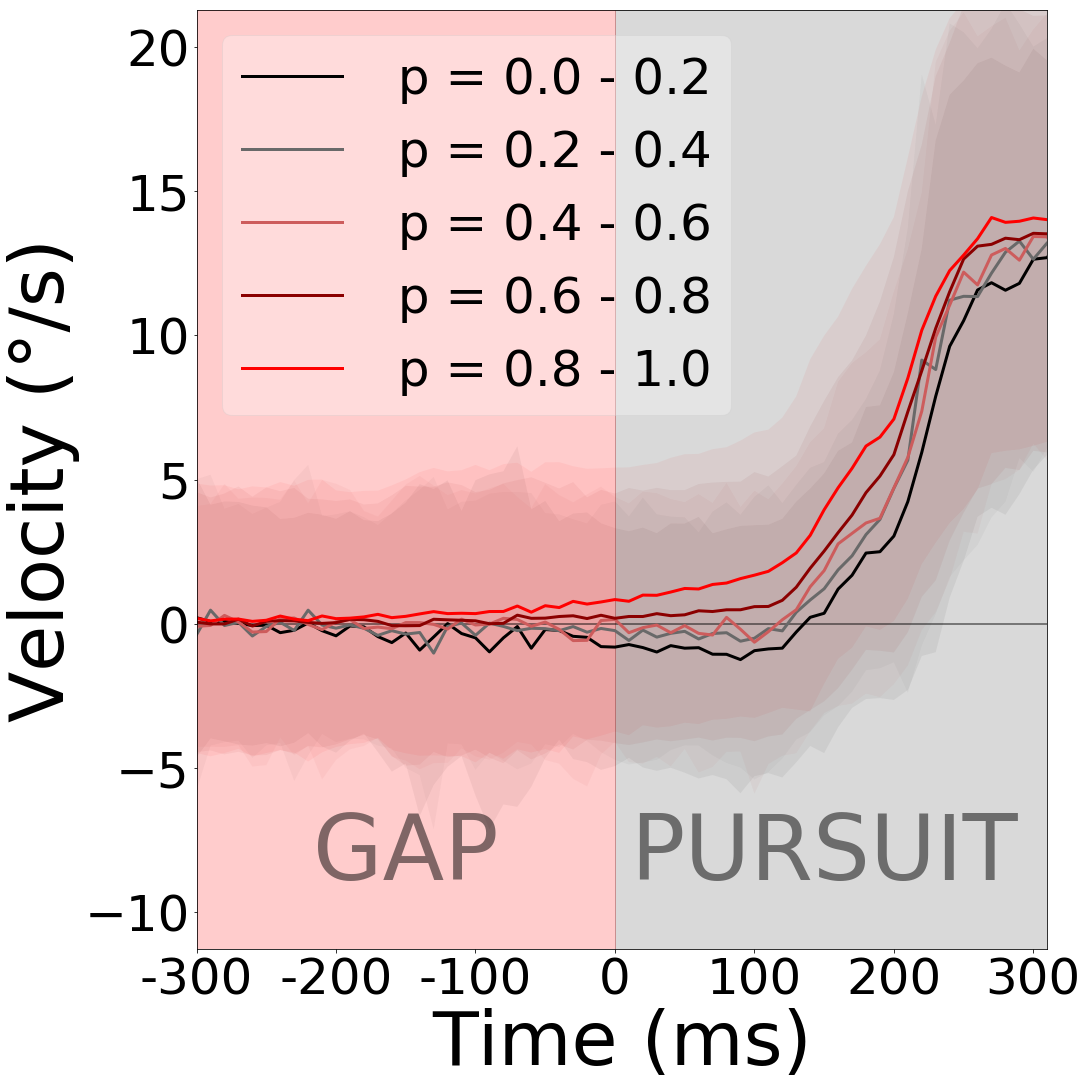

In [8]:
fig_width = 15
t_titre = 0
t_label = 30*3

delta = 0.2
#color = ['b','g','r','c','m']
color = ['black','dimgrey','indianred','darkred','red']
#color = ['black','grey','darkgrey','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']

fig, axs = plt.subplots(1, 1, figsize=(1*fig_width, 1*fig_width), constrained_layout=True)#/(1.6180*1)))
axs = Trace_Moyenne_P_reel(delta, color, '', mean=True, ax=axs)

plt.show()
for ext in exts:
    fig.savefig('ms/figures/1_B_Trace_moyenne' + ext, dpi=400)
fig.savefig('figures/Trace_moyenne.pdf', dpi=400)